In [19]:
from typing import Dict, List
import json
from collections import namedtuple
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric_names = [
    "Improvement::CII",
    "Improvement::LSR",
    "Improvement::FSIM",
    "Distortion::PSNR",
    "Distortion::SSIM",
    "Distortion::LPIPS",
    "Artifacts::RNS",
    "Artifacts::BRISQUE",
]


In [20]:
MetricResult = namedtuple("MetricResult", ("metric_name", "result"))


def deserialize_metrics(json_str: str) -> Dict[str, Dict[str, List[MetricResult]]]:
    data = json.loads(json_str)

    deserialized_data = {}

    for image_hash, experiments in data.items():
        deserialized_data[image_hash] = {}

        for exp_name, metrics_dict in experiments.items():
            # Convert dictionary back to list of MetricResult with Python floats
            metrics_list = [
                MetricResult(metric_name=metric_name, result=float(result))
                for metric_name, result in metrics_dict.items()
            ]

            deserialized_data[image_hash][exp_name] = metrics_list

    return deserialized_data


def build_experiment_dataframes(
    metrics_dict: Dict[str, Dict[str, List[MetricResult]]],
) -> Dict[str, pd.DataFrame]:
    """
    Para cada experimento, crea un DataFrame donde cada fila es una imagen
    y cada columna corresponde a una métrica con su resultado.
    Devuelve un diccionario experimento -> DataFrame.
    """
    # Identificar todos los experimentos únicos
    experiments = set()
    for img_exps in metrics_dict.values():
        experiments.update(img_exps.keys())

    # Inicializar dict de DataFrames
    dfs: Dict[str, pd.DataFrame] = {}
    for exp in experiments:
        rows = []
        for image_id, img_exps in metrics_dict.items():
            if exp in img_exps:
                row = {"image_id": image_id}
                for metric in img_exps[exp]:
                    row[metric.metric_name] = metric.result
                rows.append(row)
        dfs[exp] = pd.DataFrame(rows).set_index("image_id")
    return dfs

In [21]:
with open("exp_out/out.json", "r") as f:
    sample_json = f.read()

metrics = deserialize_metrics(sample_json)
dfs = build_experiment_dataframes(metrics)
# %%
for name, df in dfs.items():
    df["Experiment"] = name


combined_df = pd.concat(dfs.values(), ignore_index=True)

In [22]:
combined_df

,Improvement::CII,Improvement::LSR,Improvement::FSIM,Distortion::PSNR,Distortion::SSIM,Distortion::LPIPS,Artifacts::RNS,Artifacts::BRISQUE,Experiment
0,0.817025,26.453447,0.867120,74.206873,0.999798,0.000024,0.047018,115.006317,Highpass Mask with cutoff_scale=10
1,0.815134,26.349190,0.869940,74.165729,0.999796,0.000025,0.047398,115.034760,Highpass Mask with cutoff_scale=10
2,0.811835,26.358683,0.869887,73.646540,0.999747,0.000025,0.049054,115.035461,Highpass Mask with cutoff_scale=10
3,0.517969,27.114363,0.825182,65.000353,0.997129,0.000048,0.133332,115.001526,Highpass Mask with cutoff_scale=10
4,0.470143,27.852819,0.772168,61.444875,0.993412,0.000081,0.194303,114.912506,Highpass Mask with cutoff_scale=10
...,...,...,...,...,...,...,...,...,...
580,1.772231,35.634556,0.541666,60.929542,0.993641,0.000559,0.177677,111.428436,Threshold Coefficients at 0.1
581,1.926814,43.054379,0.568653,61.473108,0.994351,0.000497,0.171831,111.086365,Threshold Coefficients at 0.1
582,1.690243,34.883041,0.542919,61.728865,0.994769,0.000519,0.164027,111.562225,Threshold Coefficients at 0.1
583,2.041832,29.690870,0.574821,61.140568,0.993913,0.000424,0.180480,109.108887,Threshold Coefficients at 0.1


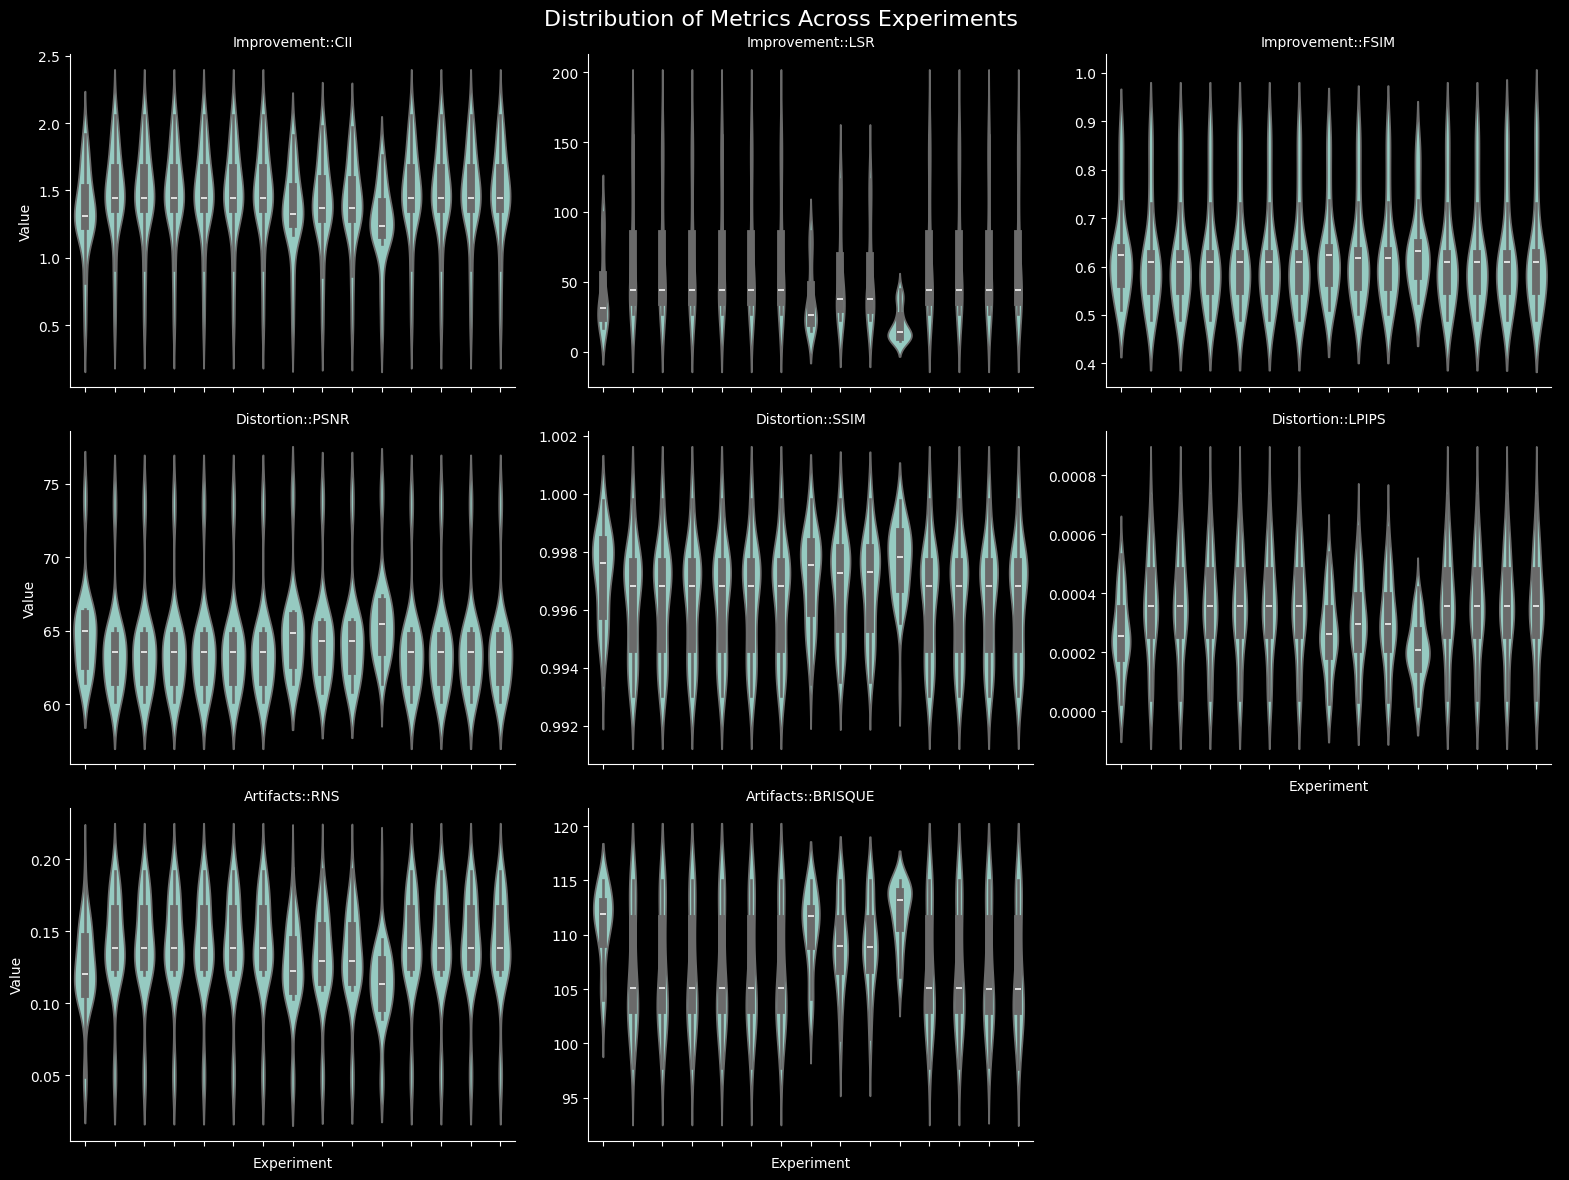

In [23]:
long_df = pd.melt(
    combined_df,
    id_vars="Experiment", # type: ignore
    value_vars=metric_names,
    var_name="Metric",
    value_name="Value",
)

g = sns.catplot(
    data=long_df,
    x="Experiment",
    y="Value",
    col="Metric",
    kind="violin",
    sharey=False,
    col_wrap=3,
    height=4,
    aspect=1.3,
)

g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Distribution of Metrics Across Experiments", fontsize=16)

plt.tight_layout()
plt.show()

In [24]:
normality_results = {}

for exp, df in dfs.items():
    normality_results[exp] = {}
    for metric in metric_names:
        values = df[metric].dropna()
        n = len(values)
        if n < 3:
            # Not enough data for normality test
            normality_results[exp][metric] = None
            continue
        if n <= 5000:
            stat, p = stats.shapiro(values)
        else:
            stat, p = stats.kstest(values, "norm", args=(values.mean(), values.std()))
        normality_results[exp][metric] = bool(p > 0.05)

normality_results

{'Highpass Mask with cutoff_scale=10': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': True,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Exponential Scale Mask with decay_rate=0.1': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': False,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Gaussian Scale Mask with center_scale=N/2, sigma=4.0': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': False,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Exponential Scale Mask with decay_rate=0.01': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': Fa

In [25]:
metric_normality = {}

for metric in metric_names:
    metric_values = combined_df[metric].dropna()
    n = len(metric_values)
    if n < 3:
        metric_normality[metric] = None
        continue
    if n <= 5000:
        stat, p = stats.shapiro(metric_values)
    else:
        stat, p = stats.kstest(
            metric_values, "norm", args=(metric_values.mean(), metric_values.std())
        )
    metric_normality[metric] = bool(p > 0.05)

metric_normality

{'Improvement::CII': False,
 'Improvement::LSR': False,
 'Improvement::FSIM': False,
 'Distortion::PSNR': False,
 'Distortion::SSIM': False,
 'Distortion::LPIPS': False,
 'Artifacts::RNS': False,
 'Artifacts::BRISQUE': False}

In [26]:
from scipy.stats import mannwhitneyu
from itertools import combinations

for metric in metric_names:
    print(f"Pairwise comparisons for {metric}:")
    exp_names = list(dfs.keys())
    for exp1, exp2 in combinations(exp_names, 2):
        values1 = dfs[exp1][metric].dropna()
        values2 = dfs[exp2][metric].dropna()
        if len(values1) < 2 or len(values2) < 2:
            print(f"  Not enough data for {exp1} vs {exp2}")
            continue
        stat, p = mannwhitneyu(values1, values2, alternative="two-sided")
        print(f"  {exp1} vs {exp2}: U={stat:.3f}, p={p:.4f}", end=" ")
        if p < 0.05:
            print("(significant)")
        else:
            print("(not significant)")
    print()

Pairwise comparisons for Improvement::CII:
  Highpass Mask with cutoff_scale=10 vs Exponential Scale Mask with decay_rate=0.1: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Gaussian Scale Mask with center_scale=N/2, sigma=4.0: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Exponential Scale Mask with decay_rate=0.01: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Gaussian Scale Mask with center_scale=N/2, sigma=6.0: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Enhance Energy by 1.5: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Threshold Coefficients at 0.001: U=518.000, p=0.0156 (significant)
  Highpass Mask with cutoff_scale=10 vs Bandpass Mask with low_scale=15, high_scale=20: U=710.000, p=0.6173 (not significant)
  Highpass Mask with cutoff_scale=10 vs Highpass Mask with cutoff_scale=5: U=631.000, p=0.1973 (not significant)
  Highpass Mask with 

In [27]:
# Define metric directions: True if higher is better, False if lower is better
metric_directions = {
    "Improvement::CII": True,
    "Improvement::LSR": True,
    "Improvement::FSIM": True,
    "Distortion::PSNR": True,
    "Distortion::SSIM": True,
    "Distortion::LPIPS": False,
    "Artifacts::RNS": False,
    "Artifacts::BRISQUE": False,
}


def is_different(metric, exp1, exp2, dfs):
    values1 = dfs[exp1][metric].dropna()
    values2 = dfs[exp2][metric].dropna()
    if len(values1) < 2 or len(values2) < 2:
        print(f"  Not enough data for {exp1} vs {exp2}")
        return False
    _, p = mannwhitneyu(values1, values2, alternative="two-sided")
    return p < 0.05


def is_different_anova(metric, exp1, exp2, dfs):
    """
    Uses one-way ANOVA (scipy.stats.f_oneway) to test if the means of two samples are significantly different.
    Assumes normality and equal variances of the samples.
    Returns True if p < 0.05, otherwise False.
    """
    values1 = dfs[exp1][metric].dropna()
    values2 = dfs[exp2][metric].dropna()
    if len(values1) < 2 or len(values2) < 2:
        print(f"  Not enough data for {exp1} vs {exp2}")
        return False
    _, p = stats.f_oneway(values1, values2)
    return p < 0.05


# Define expected/ideal values for each metric
expected_values = {
    "Improvement::CII": 1.0,
    "Improvement::LSR": 1.0,
    "Improvement::FSIM": 1.0,
    "Distortion::PSNR": float("inf"),
    "Distortion::SSIM": 1.0,
    "Distortion::LPIPS": 0.0,
    "Artifacts::RNS": 0.0,
    "Artifacts::BRISQUE": 0.0,
}


def compare_experiments(
    exp1,
    exp2,
    dfs,
    metric_directions=metric_directions,
    expected_values=expected_values,
):
    """
    Compare two experiments across all metrics using expected values.
    Returns a dict: metric -> closer experiment (or 'tie')
    """
    results = {}
    df1 = dfs[exp1]
    df2 = dfs[exp2]
    common_images = df1.index.intersection(df2.index)
    for metric, higher_is_better in metric_directions.items():
        if metric not in df1.columns or metric not in df2.columns:
            results[metric] = "N/A"
            continue

        significant = is_different(metric, exp1, exp2, dfs)
        if not significant:
            results[metric] = "tie"
            continue

        vals1 = df1.loc[common_images, metric].dropna()
        vals2 = df2.loc[common_images, metric].dropna()
        valid_idx = vals1.index.intersection(vals2.index)
        if len(valid_idx) == 0:
            results[metric] = "N/A"
            continue
        mean1 = vals1.loc[valid_idx].mean()
        mean2 = vals2.loc[valid_idx].mean()
        ideal = expected_values.get(metric, None)
        if ideal is None:
            results[metric] = "N/A"
            continue
        # For infinite ideal (e.g., PSNR), use higher value as closer
        if ideal == float("inf"):
            if abs(mean1 - mean2) < 1e-6:
                results[metric] = "tie"
            elif mean1 > mean2:
                results[metric] = exp1
            else:
                results[metric] = exp2
        else:
            dist1 = abs(mean1 - ideal)
            dist2 = abs(mean2 - ideal)
            if abs(dist1 - dist2) < 1e-6:
                results[metric] = "tie"
            elif dist1 < dist2:
                results[metric] = exp1
            else:
                results[metric] = exp2
    return results


In [28]:
# Example usage:
exp_names = list(dfs.keys())
comparison_results = {}
for exp1, exp2 in combinations(exp_names, 2):
    comparison_results[(exp1, exp2)] = compare_experiments(exp1, exp2, dfs)

In [29]:
def get_best_experiment(comparison_results):
    """
    Given the pairwise comparison_results, count how many times each experiment
    is closer to the ideal value (i.e., 'wins' per metric across all pairs).
    Returns a sorted list of (experiment, win_count) tuples.
    """
    win_counts = {}
    for (exp1, exp2), metrics in comparison_results.items():
        for metric, winner in metrics.items():
            if winner in (exp1, exp2):
                win_counts[winner] = win_counts.get(winner, 0) + 1
    # Sort by win count descending
    return sorted(win_counts.items(), key=lambda x: x[1], reverse=True)


best_experiments = get_best_experiment(comparison_results)
print("Best experiments by win count:")

for rank, (exp, count) in enumerate(best_experiments, 1):
    print(f"{rank}. {exp}: {count} wins")

Best experiments by win count:
1. Gaussian Scale Mask with center_scale=N/2, sigma=1.0: 77 wins
2. Highpass Mask with cutoff_scale=10: 62 wins
3. Bandpass Mask with low_scale=15, high_scale=20: 62 wins
4. Highpass Mask with cutoff_scale=5: 12 wins
5. Bandpass Mask with low_scale=5, high_scale=10: 12 wins
6. Exponential Scale Mask with decay_rate=0.1: 5 wins
7. Gaussian Scale Mask with center_scale=N/2, sigma=4.0: 5 wins
8. Exponential Scale Mask with decay_rate=0.01: 5 wins
9. Gaussian Scale Mask with center_scale=N/2, sigma=6.0: 5 wins
10. Enhance Energy by 1.5: 5 wins
11. Threshold Coefficients at 0.001: 5 wins
12. Enhance Energy by 10: 5 wins
13. Enhance Energy by 3.0: 5 wins
14. Threshold Coefficients at 0.05: 5 wins
15. Threshold Coefficients at 0.1: 5 wins


In [30]:
def get_best_experiment_with_lsr_priority(comparison_results):
    """
    Like get_best_experiment, but LSR metric counts as 3 'wins' (most important).
    """
    win_counts = {}
    for (exp1, exp2), metrics in comparison_results.items():
        for metric, winner in metrics.items():
            if winner in (exp1, exp2):
                # Give LSR extra weight
                weight = 3 if metric == "Distortion::SSIM" else 1
                win_counts[winner] = win_counts.get(winner, 0) + weight
    return sorted(win_counts.items(), key=lambda x: x[1], reverse=True)


best_experiments_lsr = get_best_experiment_with_lsr_priority(comparison_results)
print("Best experiments by win count (LSR prioritized):")
for rank, (exp, count) in enumerate(best_experiments_lsr, 1):
    print(f"{rank}. {exp}: {count} weighted wins")

Best experiments by win count (LSR prioritized):
1. Gaussian Scale Mask with center_scale=N/2, sigma=1.0: 101 weighted wins
2. Highpass Mask with cutoff_scale=10: 82 weighted wins
3. Bandpass Mask with low_scale=15, high_scale=20: 82 weighted wins
4. Highpass Mask with cutoff_scale=5: 12 weighted wins
5. Bandpass Mask with low_scale=5, high_scale=10: 12 weighted wins
6. Exponential Scale Mask with decay_rate=0.1: 5 weighted wins
7. Gaussian Scale Mask with center_scale=N/2, sigma=4.0: 5 weighted wins
8. Exponential Scale Mask with decay_rate=0.01: 5 weighted wins
9. Gaussian Scale Mask with center_scale=N/2, sigma=6.0: 5 weighted wins
10. Enhance Energy by 1.5: 5 weighted wins
11. Threshold Coefficients at 0.001: 5 weighted wins
12. Enhance Energy by 10: 5 weighted wins
13. Enhance Energy by 3.0: 5 weighted wins
14. Threshold Coefficients at 0.05: 5 weighted wins
15. Threshold Coefficients at 0.1: 5 weighted wins


In [31]:
def compare_metrics(
    df_a: pd.DataFrame,
    df_b: pd.DataFrame,
    weights: Dict[str, float] = {},
    lower_is_better=['Distortion::LPIPS', 'Artifacts::RNS', 'Artifacts::BRISQUE'],
    ignore=["image_id", "Experiment"],
):
    df_a_filtered = df_a.drop(columns=[col for col in ignore if col in df_a.columns])
    df_b_filtered = df_b.drop(columns=[col for col in ignore if col in df_b.columns])

    value_a = 0
    value_b = 0

    for metric in df_a_filtered.columns:
        values_a = np.array(df_a_filtered[metric].dropna().values)
        values_b = np.array(df_b_filtered[metric].dropna().values)

        if len(values_a) < 3 or len(values_b) < 3:
            print(f"{metric}: Not enough data for normality test.")
            continue

        if len(values_a) <= 5000:
            _, p_a = stats.shapiro(values_a)
        else:
            _, p_a = stats.kstest(
                values_a, "norm", args=(values_a.mean(), values_a.std())
            )
        if len(values_b) <= 5000:
            _, p_b = stats.shapiro(values_b)
        else:
            _, p_b = stats.kstest(
                values_b, "norm", args=(values_b.mean(), values_b.std())
            )

        normal_a = p_a < 0.05
        normal_b = p_b < 0.05

        if normal_a and normal_b:
            _, p = stats.ttest_ind(values_a, values_b, equal_var=False)
        else:
            _, p = stats.mannwhitneyu(values_a, values_b, alternative="two-sided")

        different_samples = p < 0.05  # type: ignore

        if not different_samples:
            continue

        weight = weights.get(metric, 1)

        if values_a.mean() > values_b.mean() and metric not in lower_is_better:
            value_a += weight
            print(f"A wsins on {metric} with value {values_a.mean()} vs {values_b.mean()}")
        else:
            value_b += weight
            print(f"B wisns on {metric} with value {values_b.mean()} vs {values_a.mean()}")
    
    return value_a - value_b

In [32]:
experiments = list(dfs.keys())

In [33]:
weights = {
    "Improvement::CII": 8.0,
    "Improvement::LSR": 8.0,
    "Improvement::FSIM": 1.0,
    "Distortion::PSNR": 1.0,
    "Distortion::SSIM": 26.0,
    "Distortion::LPIPS": 1.0,
    "Artifacts::RNS": 1.0,
    "Artifacts::BRISQUE": 1.0,
}

In [34]:
from collections import defaultdict

grouped_experiments = defaultdict(list)
for exp in experiments:
    key = exp[:3]
    grouped_experiments[key].append(exp)

grouped_experiments = list(grouped_experiments.values())

In [35]:
def compare(exp_group):
    for exp_a, exp_b in combinations(exp_group, 2):
        value = compare_metrics(dfs[exp_a], dfs[exp_b], weights=weights)
        
        if value < 0:
            print(f"El experimento '{exp_b}'. gana sobre '{exp_a}' con una puntuacion de {value}")
        elif value > 0:
            print(f"El experimento '{exp_a}'. gana sobre '{exp_b}' con una puntuacion de {value}")
        else:
            print(f"El experimento '{exp_a}'. es equivalente al experimento '{exp_b}'")
    print("="*100)

for exp_group in grouped_experiments:
    compare(exp_group)


B wisns on Artifacts::BRISQUE with value 108.93003806089743 vs 110.89647576747797
El experimento 'Highpass Mask with cutoff_scale=5'. gana sobre 'Highpass Mask with cutoff_scale=10' con una puntuacion de -1.0
El experimento 'Exponential Scale Mask with decay_rate=0.1'. es equivalente al experimento 'Exponential Scale Mask with decay_rate=0.01'
El experimento 'Gaussian Scale Mask with center_scale=N/2, sigma=4.0'. es equivalente al experimento 'Gaussian Scale Mask with center_scale=N/2, sigma=6.0'
A wsins on Improvement::CII with value 1.4690337303357246 vs 1.2515009618722475
A wsins on Improvement::LSR with value 67.14705022176106 vs 19.27737463437594
B wisns on Distortion::PSNR with value 65.73153915488041 vs 63.76768221157099
B wisns on Distortion::SSIM with value 0.997636020887174 vs 0.996329691382387
B wisns on Distortion::LPIPS with value 0.00020747634843223167 vs 0.00035580550852151087
B wisns on Artifacts::RNS with value 0.11294640103975932 vs 0.14054247316641685
B wisns on Arti

In [36]:
winners = [
    "Threshold Coefficients at 0.001",
    "Exponential Scale Mask with decay_rate=0.01",
    "Highpass Mask with cutoff_scale=10",
    "Gaussian Scale Mask with center_scale=N/2, sigma=1.0",
    "Bandpass Mask with low_scale=5, high_scale=10",
    "Enhance Energy by 10",
]

compare(winners)

El experimento 'Threshold Coefficients at 0.001'. es equivalente al experimento 'Exponential Scale Mask with decay_rate=0.01'
A wsins on Improvement::LSR with value 67.14705022176106 vs 43.410172486916565
B wisns on Distortion::SSIM with value 0.997191927052954 vs 0.996329691382387
B wisns on Distortion::LPIPS with value 0.0002614287543390394 vs 0.00035580550852151087
B wisns on Artifacts::RNS with value 0.12350736453365056 vs 0.14054247316641685
B wisns on Artifacts::BRISQUE with value 110.89647576747797 vs 106.81335605719151
El experimento 'Highpass Mask with cutoff_scale=10'. gana sobre 'Threshold Coefficients at 0.001' con una puntuacion de -21.0
A wsins on Improvement::CII with value 1.4690337303357246 vs 1.2515009618722475
A wsins on Improvement::LSR with value 67.14705022176106 vs 19.27737463437594
B wisns on Distortion::PSNR with value 65.73153915488041 vs 63.76768221157099
B wisns on Distortion::SSIM with value 0.997636020887174 vs 0.996329691382387
B wisns on Distortion::LPIP